<a href="https://colab.research.google.com/github/CoGian/Detection-of-toxic-comments-and-minimization-of-unintended-model-bias-using-neural-networks/blob/master/EDA_and_Text_Preprocessing_on_jigsaw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset and Parameter Initialization 

In [ ]:
from google.colab import drive
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import wordcloud
from wordcloud import WordCloud
# import NLTK mainly for stopwords
import nltk
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.tokenize import  word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from PIL import Image
!pip install emoji
import emoji
from collections import Counter
from itertools import chain
import pickle
import operator
import string
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Mount Google Drive

In [ ]:
!python --version

Python 3.6.9


In [ ]:
!pip freeze

absl-py==0.9.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
argon2-cffi==20.1.0
asgiref==3.2.10
astor==0.8.1
astropy==4.0.1.post1
astunparse==1.6.3
atari-py==0.2.6
atomicwrites==1.4.0
attrs==19.3.0
audioread==2.1.8
autograd==1.3
Babel==2.8.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.1.5
blis==0.4.1
bokeh==2.1.1
boto==2.49.0
boto3==1.14.33
botocore==1.17.33
Bottleneck==1.3.2
branca==0.4.1
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.1.1
catalogue==1.0.0
certifi==2020.6.20
cffi==1.14.1
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.4.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.2.1
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.5
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.3
Cython==0.29.21
daft==0.0.4
dask==2.12.0
dataclasses==0.7
datascience==0.10.6
decorator==4.4.2
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.2
distributed==1.25.3
Django==3.0.8
dlib==19.18.0
dm-tree==0.1.5
doco

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will use only train dataset for EDA and pretrained word vectors from GloVe Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors) .

In [ ]:
TRAIN_DATASET_PATH = '/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/data/train.csv'
TEST_PUBLIC_DATASET_PATH = '/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/data/test_public_expanded.csv'
TEST_PRIVATE_DATASET_PATH = '/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/data/test_private_expanded.csv'
GLOVE_EMBEDDING_PATH = '/content/drive/My Drive/Glove/glove.840B.300d.pkl'
CRAWL_EMBEDDING_PATH = "/content/drive/My Drive/Crawl/crawl-300d-2M.pkl"

Read the datasets 

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_public_df =  pd.read_csv(TEST_PUBLIC_DATASET_PATH)
test_private_df = pd.read_csv(TEST_PRIVATE_DATASET_PATH)

In [ ]:
len(test_public_df)

97320

In [ ]:
len(test_private_df)

97320

Create lists with column names 

In [ ]:
TARGET_COLUMN = 'target'
GENDER_IDENTITIES = ['male', 'female', 'transgender', 'other_gender']
SEXUAL_ORIENTATION_IDENTITIES = ['heterosexual', 'homosexual_gay_or_lesbian', 'bisexual',
'other_sexual_orientation']
RELIGION_IDENTINTIES = ['christian', 'jewish', 'muslim', 'hindu', 'buddhist',
'atheist', 'other_religion']
RACE_IDENTINTIES = ['black', 'white', 'latino', 'asian',
'other_race_or_ethnicity']
DISABILITY_IDENTINTIES = ['physical_disability','intellectual_or_learning_disability',
                          'psychiatric_or_mental_illness', 'other_disability']
IDENTITY_COLUMNS = GENDER_IDENTITIES + SEXUAL_ORIENTATION_IDENTITIES + RELIGION_IDENTINTIES + RACE_IDENTINTIES + DISABILITY_IDENTINTIES
IDENTITY_COLUMNS  = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness'
  ] 
AUX_COLUMNS = ['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
REACTION_COLUMNS = ['funny', 'wow',	'sad',	'likes',	'disagree']

# Exploratory Data Analysis

## Understanding the Data scheme

Print the first 5 samples 

In [ ]:
train_df = train_df[['id']+["comment_text"]+AUX_COLUMNS+IDENTITY_COLUMNS]
train_df.head()

,id,comment_text,target,severe_toxicity,obscene,identity_attack,insult,threat,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
0,59848,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59849,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59852,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,59855,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59856,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
num_of_samples = len(train_df)
print('Train size: {:d}'.format(num_of_samples))

Train size: 1804874


In [ ]:
# check for amount of missing(null) values in every column αnd print the precentage of them. 
null_columns=train_df.columns[train_df.isnull().any()]
print(train_df[null_columns].isnull().sum() / num_of_samples * 100)

male                             77.553558
female                           77.553558
homosexual_gay_or_lesbian        77.553558
christian                        77.553558
jewish                           77.553558
muslim                           77.553558
black                            77.553558
white                            77.553558
psychiatric_or_mental_illness    77.553558
dtype: float64


Check the frequency of lengths of training sentences

In [ ]:
# tokenize
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=False)
tokenizer.fit_on_texts(list(train_df["comment_text"].astype(str)))
x_train = tokenizer.texts_to_sequences(list(train_df["comment_text"].astype(str)))

# count lengths 
training_sentence_lengths = [len(tokens) for tokens in x_train]
print("Max sentence length is %s" % max(training_sentence_lengths))
targets_n_lens = pd.DataFrame(data=train_df[TARGET_COLUMN],columns=[TARGET_COLUMN])
targets_n_lens['lens'] = training_sentence_lengths

Max sentence length is 317


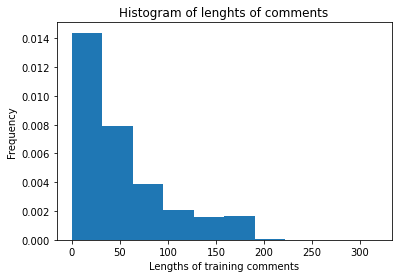

In [ ]:
#plot hist 
plt.hist(training_sentence_lengths, density=True, bins=10)  # arguments are passed to np.histogram
plt.title("Histogram of lenghts of comments")
plt.ylabel('Frequency')
plt.xlabel('Lengths of training comments')
plt.show()

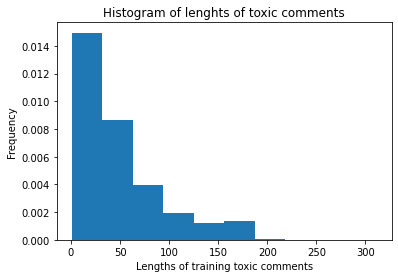

In [ ]:
plt.hist(targets_n_lens[targets_n_lens[TARGET_COLUMN] >= .5]['lens'].values, density=True, bins=10)  # arguments are passed to np.histogram
plt.title("Histogram of lenghts of toxic comments")
plt.ylabel('Frequency')
plt.xlabel('Lengths of training toxic comments');
plt.show()

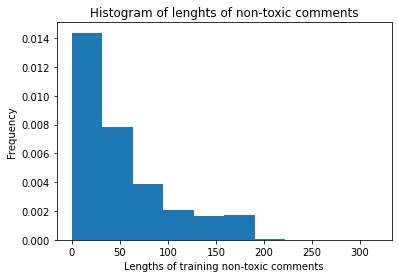

In [ ]:
plt.hist(targets_n_lens[targets_n_lens[TARGET_COLUMN] < .5]['lens'].values, density=True, bins=10)  # arguments are passed to np.histogram
plt.title("Histogram of lenghts of non-toxic comments")
plt.ylabel('Frequency')
plt.xlabel('Lengths of training non-toxic comments');
plt.show()

## Understanding the Toxic Comments with Identity

In [ ]:
num_of_non_toxic_samples = int(train_df[train_df.target < 0.5][TARGET_COLUMN].count())
num_of_toxic_samples = num_of_samples - num_of_non_toxic_samples

print('Nummer of samples: ',num_of_samples)
print('Nummer of non-toxic samples: {:d} ,percentage: {:.2f}%'.format(num_of_non_toxic_samples , (num_of_non_toxic_samples/num_of_samples)*100)) 
print('Nummer of toxic samples: {:d} ,percentage: {:.2f}%'.format(num_of_toxic_samples , (num_of_toxic_samples/num_of_samples)*100)) 

Nummer of samples:  1804874
Nummer of non-toxic samples: 1660540 ,percentage: 92.00%
Nummer of toxic samples: 144334 ,percentage: 8.00%


Let's drop the samples without identity and calculate the previous stats 

In [ ]:
train_df_with_identity = train_df.loc[:, AUX_COLUMNS + IDENTITY_COLUMNS ].dropna()
num_of_samples_with_identity =  len(train_df_with_identity)
num_of_toxic_samples_with_identity = int(train_df_with_identity[train_df_with_identity.target >= 0.5][TARGET_COLUMN].count())
num_of_non_toxic_samples_with_identity = num_of_samples_with_identity - num_of_toxic_samples_with_identity

print('Number of samples with identity: {:d}'.format(num_of_samples_with_identity)) 
print('Nummer of non-toxic samples with identity: {:d} ,percentage: {:.2f}%'.format(num_of_non_toxic_samples_with_identity , (num_of_non_toxic_samples_with_identity/num_of_samples_with_identity)*100)) 
print('Nummer of toxic samples with identity: {:d} ,percentage: {:.2f}%'.format(num_of_toxic_samples_with_identity , (num_of_toxic_samples_with_identity/num_of_samples_with_identity)*100)) 

Number of samples with identity: 405130
Nummer of non-toxic samples with identity: 359095 ,percentage: 88.64%
Nummer of toxic samples with identity: 46035 ,percentage: 11.36%


Let's plot the results 

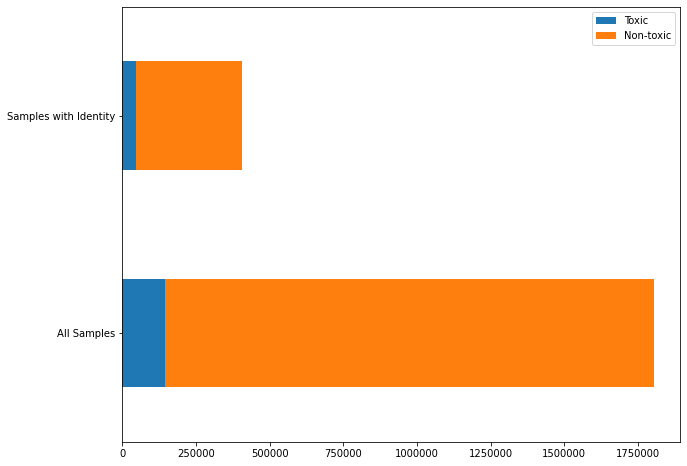

In [ ]:
counts_of_samples = pd.DataFrame([['All Samples',num_of_toxic_samples,num_of_non_toxic_samples],
                                  ['Samples with Identity',num_of_toxic_samples_with_identity,num_of_non_toxic_samples_with_identity]],
                                 columns = ['','Toxic','Non-toxic'])
counts_of_samples.set_index('',inplace=True)
plot1 = counts_of_samples.plot(kind='barh', stacked=True, figsize=(10,8), fontsize=10)
plot1.ticklabel_format(style='plain', axis='x')

Count the samples in every subgroup

In [ ]:
num_of_samples_in_subgroups = train_df_with_identity[(train_df_with_identity[IDENTITY_COLUMNS] > 0)][IDENTITY_COLUMNS].count()
num_of_samples_in_subgroups = num_of_samples_in_subgroups.to_frame(name='count')

Count the toxic samples in every subgroup

In [ ]:
# first get all samples that have an identity and are toxic 
toxic_samples_with_identity = train_df_with_identity[train_df_with_identity[TARGET_COLUMN] >= 0.5 ]
num_of__toxic_samples_in_subgroups = toxic_samples_with_identity[toxic_samples_with_identity[IDENTITY_COLUMNS] > 0][IDENTITY_COLUMNS].count()
num_of__toxic_samples_in_subgroups = num_of__toxic_samples_in_subgroups.to_frame(name='toxic_count')

In [ ]:
subgroup_stats =  (num_of__toxic_samples_in_subgroups.toxic_count /  num_of_samples_in_subgroups['count'] ) * 100
subgroup_stats = subgroup_stats.to_frame(name='toxic percentage')
subgroup_stats['toxic'] = num_of__toxic_samples_in_subgroups.toxic_count
subgroup_stats['non_toxic'] = num_of_samples_in_subgroups['count'] - num_of__toxic_samples_in_subgroups.toxic_count 
subgroup_stats['total'] = num_of_samples_in_subgroups['count']

subgroup_stats.sort_values(by= 'toxic' , ascending=False , inplace=True)

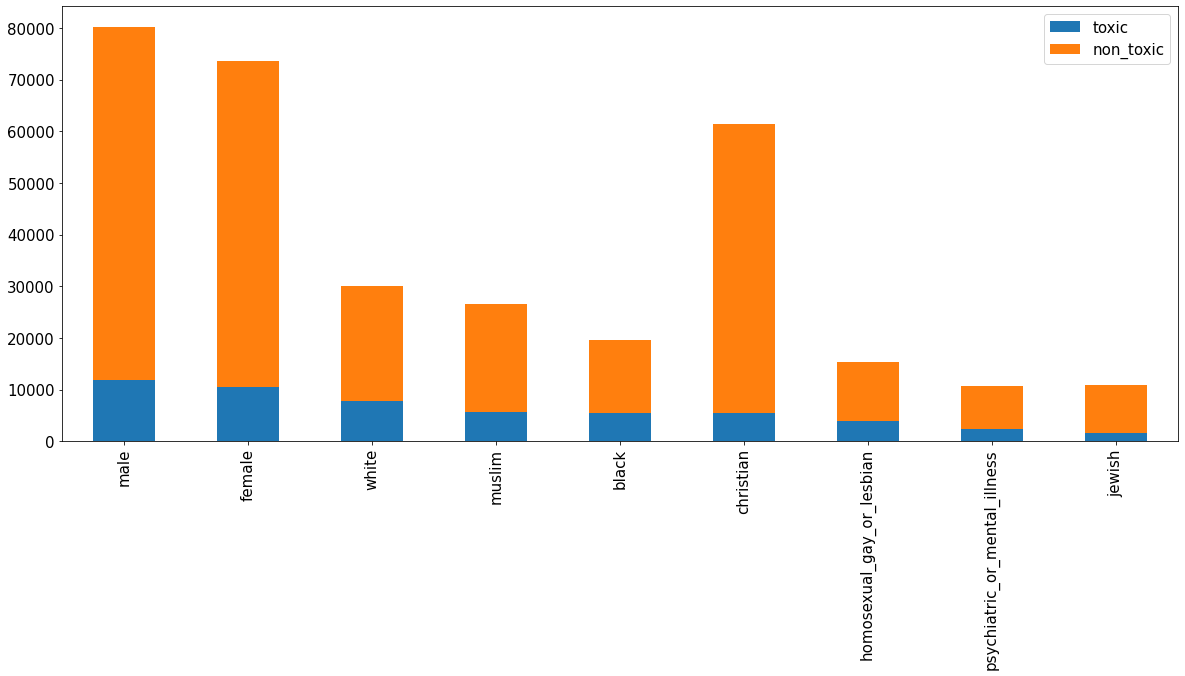

In [ ]:
subgroup_stats[['toxic','non_toxic']].plot(kind='bar', stacked=True, figsize=(20,8), fontsize=15).legend(prop={'size': 15})

In [ ]:
# multiply each identity with the target
weighted_toxic_percentage = train_df_with_identity[IDENTITY_COLUMNS].apply(lambda x: np.asarray(x) * np.asarray(train_df_with_identity[TARGET_COLUMN])).sum()
# devide the number of samples in each subgroup 
weighted_toxic_percentage = (weighted_toxic_percentage / num_of_samples_in_subgroups['count']) * 100
weighted_toxic_percentage.sort_values(ascending=False, inplace=True)

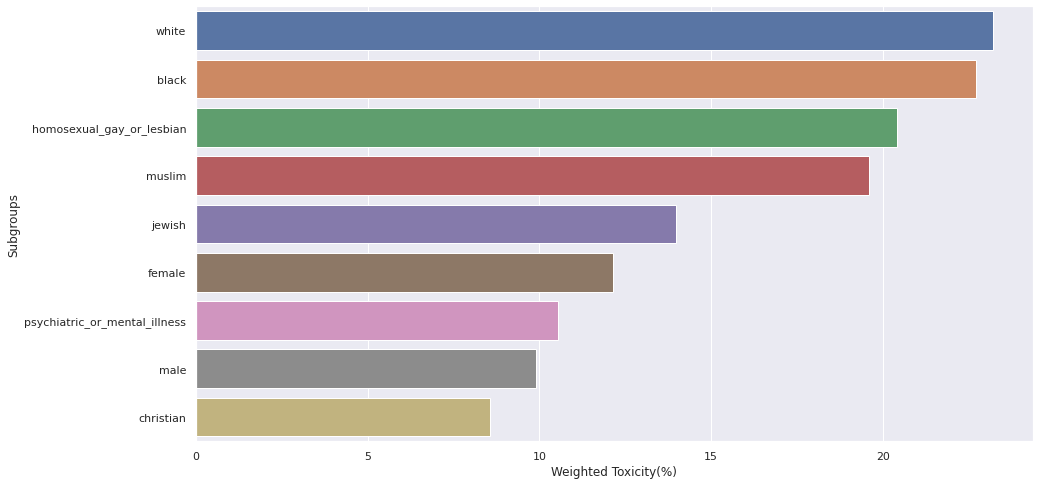

In [ ]:
plt.figure(figsize=(15,8))
sns.set(font_scale=1)
ax = sns.barplot(x = weighted_toxic_percentage.values , y = weighted_toxic_percentage.index)
plt.ylabel('Subgroups')
plt.xlabel('Weighted Toxicity(%)')
plt.show()

## Correlation and Heatmap of Identities

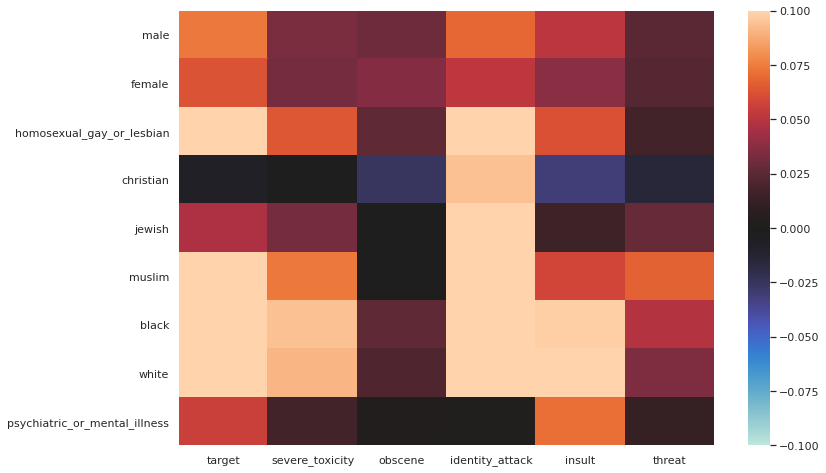

In [ ]:
rows = [{c:train_df_with_identity[f].corr(train_df_with_identity[c]) for c in [TARGET_COLUMN] + AUX_COLUMNS} for f in IDENTITY_COLUMNS]
poptoxicity_correlations = pd.DataFrame(rows, index=IDENTITY_COLUMNS)
plt.figure(figsize=(12, 8))
sns.set(font_scale=1)
ax = sns.heatmap(poptoxicity_correlations, vmin=-0.1, vmax=0.1, center=0.0)

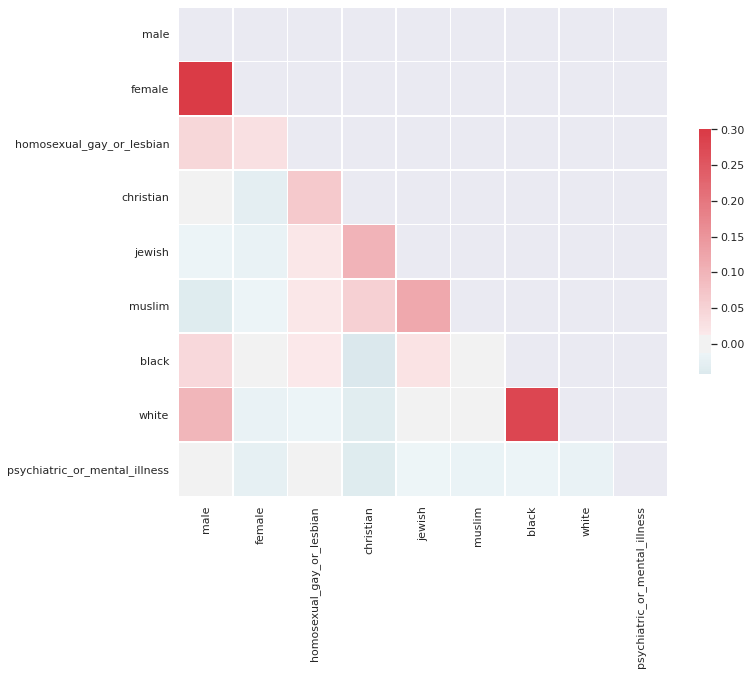

In [ ]:
# Compute the correlation matrix
corr = train_df_with_identity[IDENTITY_COLUMNS].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
sns.set(font_scale = 1)
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The heatmap plot of the correlation between the identities is very insightful. I will summarize my observations below. As always, if you see something interesting please mention it to me in the comment section.


*   It is interesting to see that strong correlations form triangular area at the edge of diagonal.

*   This basically means that there is a strong correlation between the groups of the identity (gender, religion, races, disabilities). This means, the comments where male identity is the target, female identity is also very likely to be the target.

*   In another words, in toxic and non-toxic comments, people tend to make it about one group vs another quiet frequently.






## Word Clouds

In [ ]:
# we will write a simple function to generate the wordcloud per identity group
def generate_word_cloud(identity, toxic_comments, non_toxic_comments):
    # convert stop words to sets as required by the wordcloud library
    stop_words = set(stopwords.words("english"))
    # create toxic wordcloud
    toxic_picture = '/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/images/toxic_sign.png'
    toxic_mask=np.array(Image.open(toxic_picture))
    toxic_mask=toxic_mask[:,:]
    wordcloud_toxic = WordCloud(max_words=1000, background_color="black", mask=toxic_mask ,stopwords=stop_words).generate(toxic_comments)
    # create non-toxic wordcloud
    peace_picture = '/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/images/peace_sign.png'
    peace_mask = np.array(Image.open(peace_picture))
    wordcloud_non_toxic = WordCloud(max_words=1000, background_color="black", mask=peace_mask, stopwords=stop_words).generate(non_toxic_comments)
    # draw the two wordclouds side by side using subplot
    fig = plt.figure(figsize=[20,5])
    fig.add_subplot(1, 2, 1).set_title("Toxic Wordcloud", fontsize=10)
    plt.imshow(wordcloud_toxic, interpolation="bilinear")
    plt.axis("off")
    fig.add_subplot(1, 2, 2).set_title("Non Toxic Wordcloud", fontsize=10)
    plt.imshow(wordcloud_non_toxic, interpolation="bilinear")
    plt.axis("off")
    plt.subplots_adjust(top=0.85)
    plt.suptitle('Word Cloud - {} Identity'.format(identity), size = 16)
    plt.show()

### White and Black 

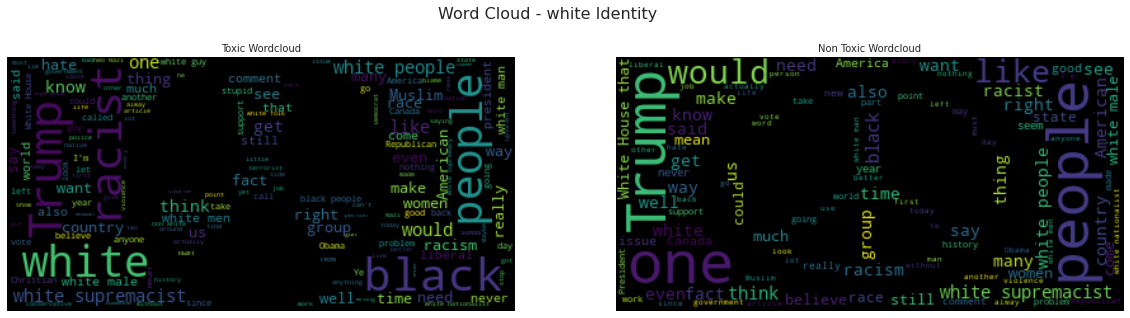

In [ ]:
identity = 'white'
# get the comments for the given identity
identity_comments = train_df[train_df[identity] > 0 ][[TARGET_COLUMN,'comment_text']]
# lets convert the comments as one long string (as needed by wordcloud)
toxic_comments = ' '.join(identity_comments[identity_comments.target >= 0.5]['comment_text'])
non_toxic_comments = ' '.join(identity_comments[identity_comments.target < 0.5]['comment_text'])
# draw the wordcloud using the function we created earlier
generate_word_cloud(identity, toxic_comments, non_toxic_comments)

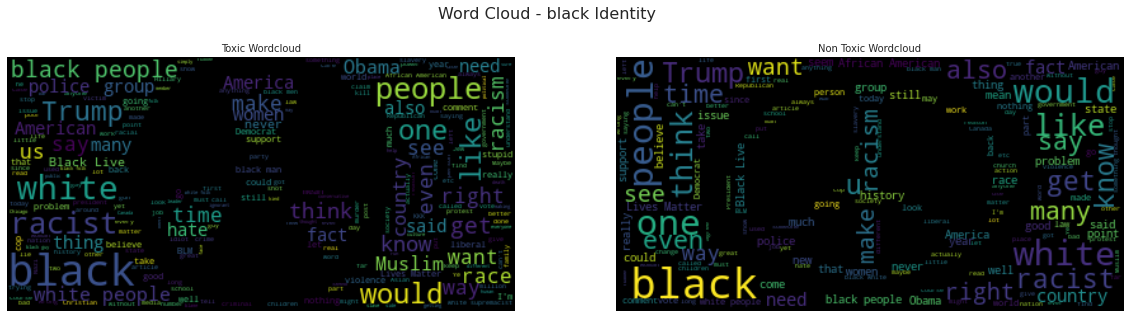

In [ ]:
identity = 'black'
# get the comments for the given identity
identity_comments = train_df[train_df[identity] > 0 ][[TARGET_COLUMN,'comment_text']]
# lets convert the comments as one long string (as needed by wordcloud)
toxic_comments = ' '.join(identity_comments[identity_comments.target >= 0.5]['comment_text'])
non_toxic_comments = ' '.join(identity_comments[identity_comments.target < 0.5]['comment_text'])
# draw the wordcloud using the function we created earlier
generate_word_cloud(identity, toxic_comments, non_toxic_comments)

### Homosexual 

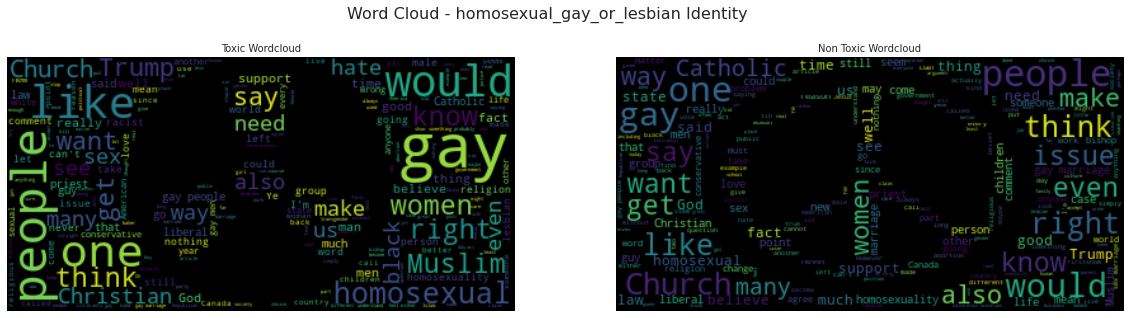

In [ ]:
identity = 'homosexual_gay_or_lesbian'
# get the comments for the given identity
identity_comments = train_df[train_df[identity] > 0 ][[TARGET_COLUMN,'comment_text']]
# lets convert the comments as one long string (as needed by wordcloud)
toxic_comments = ' '.join(identity_comments[identity_comments.target >= 0.5]['comment_text'])
non_toxic_comments = ' '.join(identity_comments[identity_comments.target < 0.5]['comment_text'])
# draw the wordcloud using the function we created earlier
generate_word_cloud(identity, toxic_comments, non_toxic_comments)

### Muslim and Jewish 

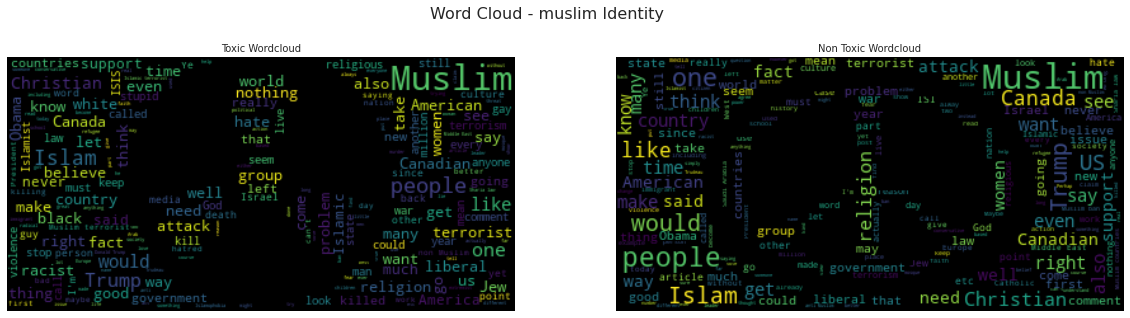

In [ ]:
identity = 'muslim'
# get the comments for the given identity
identity_comments = train_df[train_df[identity] > 0 ][[TARGET_COLUMN,'comment_text']]
# lets convert the comments as one long string (as needed by wordcloud)
toxic_comments = ' '.join(identity_comments[identity_comments.target >= 0.5]['comment_text'])
non_toxic_comments = ' '.join(identity_comments[identity_comments.target < 0.5]['comment_text'])
# draw the wordcloud using the function we created earlier
generate_word_cloud(identity, toxic_comments, non_toxic_comments)

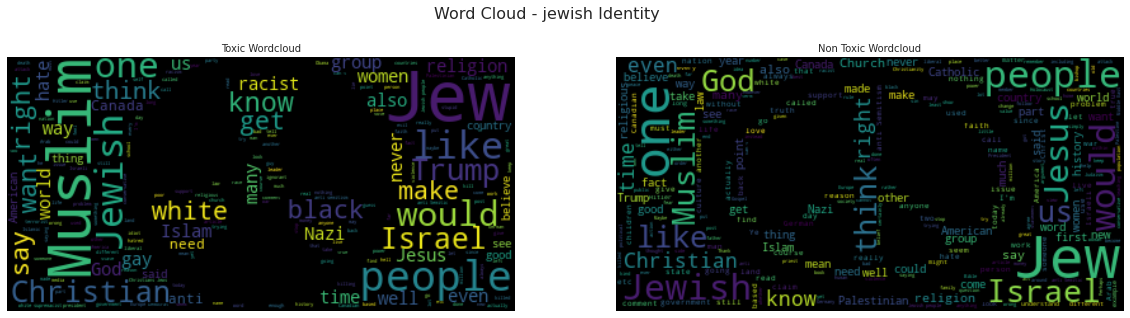

In [ ]:
identity = 'jewish'
# get the comments for the given identity
identity_comments = train_df[train_df[identity] > 0 ][[TARGET_COLUMN,'comment_text']]
# lets convert the comments as one long string (as needed by wordcloud)
toxic_comments = ' '.join(identity_comments[identity_comments.target >= 0.5]['comment_text'])
non_toxic_comments = ' '.join(identity_comments[identity_comments.target < 0.5]['comment_text'])
# draw the wordcloud using the function we created earlier
generate_word_cloud(identity, toxic_comments, non_toxic_comments)

### Female and Male

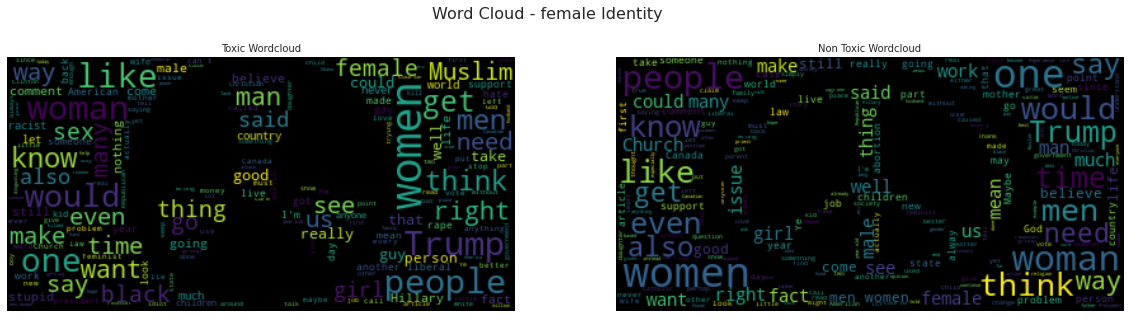

In [ ]:
identity = 'female'
# get the comments for the given identity
identity_comments = train_df[train_df[identity] > 0 ][[TARGET_COLUMN,'comment_text']]
# lets convert the comments as one long string (as needed by wordcloud)
toxic_comments = ' '.join(identity_comments[identity_comments.target >= 0.5]['comment_text'])
non_toxic_comments = ' '.join(identity_comments[identity_comments.target < 0.5]['comment_text'])
# draw the wordcloud using the function we created earlier
generate_word_cloud(identity, toxic_comments, non_toxic_comments)

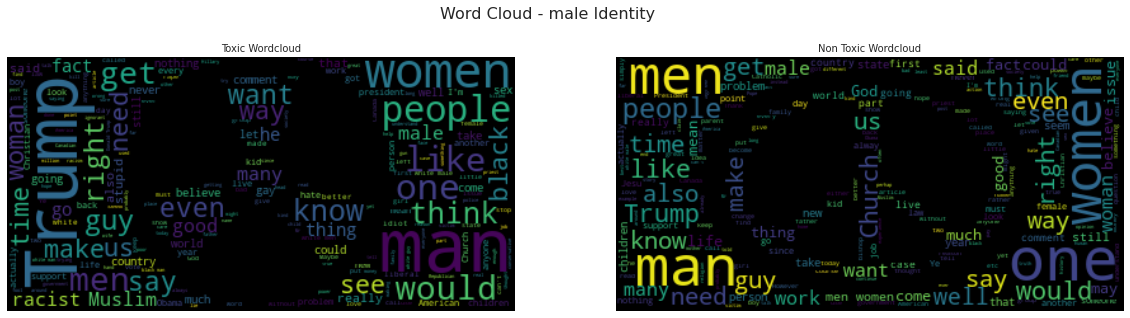

In [ ]:
identity = 'male'
# get the comments for the given identity
identity_comments = train_df[train_df[identity] > 0 ][[TARGET_COLUMN,'comment_text']]
# lets convert the comments as one long string (as needed by wordcloud)
toxic_comments = ' '.join(identity_comments[identity_comments.target >= 0.5]['comment_text'])
non_toxic_comments = ' '.join(identity_comments[identity_comments.target < 0.5]['comment_text'])
# draw the wordcloud using the function we created earlier
generate_word_cloud(identity, toxic_comments, non_toxic_comments)

### Psychiatric or mental illness

In [ ]:
identity = 'psychiatric_or_mental_illness'
# get the comments for the given identity
identity_comments = train_df[train_df[identity] > 0 ][[TARGET_COLUMN,'comment_text']]
# lets convert the comments as one long string (as needed by wordcloud)
toxic_comments = ' '.join(identity_comments[identity_comments.target >= 0.5]['comment_text'])
non_toxic_comments = ' '.join(identity_comments[identity_comments.target < 0.5]['comment_text'])
# draw the wordcloud using the function we created earlier
generate_word_cloud(identity, toxic_comments, non_toxic_comments)

### Transgender

In [ ]:
identity = 'transgender'
# get the comments for the given identity
identity_comments = train_df[train_df[identity] > 0 ][[TARGET_COLUMN,'comment_text']]
# lets convert the comments as one long string (as needed by wordcloud)
toxic_comments = ' '.join(identity_comments[identity_comments.target >= 0.5]['comment_text'])
non_toxic_comments = ' '.join(identity_comments[identity_comments.target < 0.5]['comment_text'])
# draw the wordcloud using the function we created earlier
generate_word_cloud(identity, toxic_comments, non_toxic_comments)

### Atheist

In [ ]:
identity = 'atheist'
# get the comments for the given identity
identity_comments = train_df[train_df[identity] > 0 ][[TARGET_COLUMN,'comment_text']]
# lets convert the comments as one long string (as needed by wordcloud)
toxic_comments = ' '.join(identity_comments[identity_comments.target >= 0.5]['comment_text'])
non_toxic_comments = ' '.join(identity_comments[identity_comments.target < 0.5]['comment_text'])
# draw the wordcloud using the function we created earlier
generate_word_cloud(identity, toxic_comments, non_toxic_comments)

The wordcloud above is really interesting. Looking at it, I have made the following observations:

* Although the sentiment within the sentences (probably) varies in toxic and non-toxic comments, looking at it from top word frequencies, the differences are not that big.
* Between comments about White and Black identity, there is a huge overlap!
* Comments towards homosexual have more unique set of words (as imagined) from the other identity groups. However, between toxic and non-toxic comment there isn't a big variation in terms of the high frequenty words.
* For comments about Jewish identity, the word Muslim appears frequently. After reviewing a lot of the samples of such comments I noticed that a large number of comments about Jewish identity is toxic towards Muslim identity.
* Ironically, Trump is a very frequent common topic of discussion in toxic and non-toxic comments. However, frequency of Trump appearing is more in toxic comments. "Trump" or "Trump Supporters" could be a identitity in itself =)

Do you see other interesting patterns in the visualization above? Did I make a mistake? Can I do something better? Write them down in the comment section if possible :)

## Emojis

In [ ]:
# we will use this simple function to process a string and return all the emojis as a list
def extract_emojis(str):
    return [c for c in str if c in emoji.UNICODE_EMOJI]

In [ ]:
# create a new column to state if  a row / comment has emojis 
train_df['emoji_count'] = train_df['comment_text'].apply(lambda x:1 if len(extract_emojis(x)) > 0 else 0)

In [ ]:
emoji_mean_per_identity = []

for identity in IDENTITY_COLUMNS:
    toxic_emoji_mean = train_df[(train_df[identity]> 0) & (train_df[TARGET_COLUMN] >= .5)]['emoji_count'].mean()
    non_toxic_emoji_mean = train_df[(train_df[identity]> 0) & (train_df[TARGET_COLUMN] < .5)]['emoji_count'].mean()
    emoji_mean_per_identity.append([identity, toxic_emoji_mean, non_toxic_emoji_mean])

emoji_mean_per_identity_df = pd.DataFrame(emoji_mean_per_identity, columns = ['identity','toxic','non toxic']).set_index('identity')

In [ ]:
# now we can plot our dataframe and see what we have
emoji_mean_per_identity_df.plot.bar(figsize=(15,5))
plt.ylabel('mean emojis per comment')
plt.title('Emojis usage in comments for different identities - Normalized')

This clears the picture up much better. First of all, the overall use of emoji is pretty low compared to what I see nowaydays. Furthermore, there are definetly a few comments with a rediculous number of emojis which are responsible for skewing our data in the last plot. Finally, as you can imagine; the use of emoji varies and doesn't really differentiate toxic comments and non-toxic comments.

# Preprocessing 

## Word Embeddings

In [ ]:
def load_embeddings(path):
    with open(path,'rb') as f:
        embedding_index = pickle.load(f)
    return embedding_index

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

def build_vocab(sentences, verbose =  True):
    """
    build_vocab builds a ordered dictionary of words and their frequency in your text corpus.
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

def check_coverage(vocab,embeddings_index):
  """
  goes through a given vocabulary and tries to find word vectors in your embedding matrix
  """
  known_words = {}
  unknown_words = {}
  num_known_words = 0
  num_unknown_words = 0
  for word in vocab.keys():
    try:
      known_words[word] = embeddings_index[word]
      num_known_words += vocab[word]
    except:
      unknown_words[word] = vocab[word]
      num_unknown_words += vocab[word]
      pass
    
  print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
  print('Found embeddings for  {:.2%} of all text'.format(num_known_words / (num_known_words + num_unknown_words)))
  unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

  return unknown_words

In [ ]:
import time 
tic = time.time()
glove_embeddings = load_embeddings(GLOVE_EMBEDDING_PATH)
print(f'loaded {len(glove_embeddings)} word vectors in {time.time()-tic}s')

loaded 2196008 word vectors in 41.75680375099182s


In [ ]:
vocab = build_vocab(list(train_df['comment_text'].apply(lambda x:x.split())))
unknown_words = check_coverage(vocab, glove_embeddings)
unknown_words[:10]

Found embeddings for 15.82% of vocab
Found embeddings for  89.63% of all text


[("isn't", 39964),
 ("That's", 37640),
 ("won't", 29397),
 ("he's", 24353),
 ("Trump's", 23453),
 ("aren't", 20528),
 ("wouldn't", 19544),
 ('Yes,', 19043),
 ('that,', 18283),
 ("wasn't", 18153)]

Seems like ' and other punctuation directly on or in a word is an issue. We could simply delete punctuation to fix that words, but there are better methods. Lets explore the embeddings, in particular symbols a bit. For that we first need to define "what is a symbol" in contrast to a regular letter. I nowadays use the following list for "regular" letters. And symbols are all characters not in that list.

## Delete symbols that we have no embeddings and split contractions 

In [ ]:
latin_similar = "’'‘ÆÐƎƏƐƔĲŊŒẞÞǷȜæðǝəɛɣĳŋœĸſßþƿȝĄƁÇĐƊĘĦĮƘŁØƠŞȘŢȚŦŲƯY̨Ƴąɓçđɗęħįƙłøơşșţțŧųưy̨ƴÁÀÂÄǍĂĀÃÅǺĄÆǼǢƁĆĊĈČÇĎḌĐƊÐÉÈĖÊËĚĔĒĘẸƎƏƐĠĜǦĞĢƔáàâäǎăāãåǻąæǽǣɓćċĉčçďḍđɗðéèėêëěĕēęẹǝəɛġĝǧğģɣĤḤĦIÍÌİÎÏǏĬĪĨĮỊĲĴĶƘĹĻŁĽĿʼNŃN̈ŇÑŅŊÓÒÔÖǑŎŌÕŐỌØǾƠŒĥḥħıíìiîïǐĭīĩįịĳĵķƙĸĺļłľŀŉńn̈ňñņŋóòôöǒŏōõőọøǿơœŔŘŖŚŜŠŞȘṢẞŤŢṬŦÞÚÙÛÜǓŬŪŨŰŮŲỤƯẂẀŴẄǷÝỲŶŸȲỸƳŹŻŽẒŕřŗſśŝšşșṣßťţṭŧþúùûüǔŭūũűůųụưẃẁŵẅƿýỳŷÿȳỹƴźżžẓ"
white_list = string.ascii_letters + string.digits + latin_similar + ' ' + "'"
print(white_list)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789’'‘ÆÐƎƏƐƔĲŊŒẞÞǷȜæðǝəɛɣĳŋœĸſßþƿȝĄƁÇĐƊĘĦĮƘŁØƠŞȘŢȚŦŲƯY̨Ƴąɓçđɗęħįƙłøơşșţțŧųưy̨ƴÁÀÂÄǍĂĀÃÅǺĄÆǼǢƁĆĊĈČÇĎḌĐƊÐÉÈĖÊËĚĔĒĘẸƎƏƐĠĜǦĞĢƔáàâäǎăāãåǻąæǽǣɓćċĉčçďḍđɗðéèėêëěĕēęẹǝəɛġĝǧğģɣĤḤĦIÍÌİÎÏǏĬĪĨĮỊĲĴĶƘĹĻŁĽĿʼNŃN̈ŇÑŅŊÓÒÔÖǑŎŌÕŐỌØǾƠŒĥḥħıíìiîïǐĭīĩįịĳĵķƙĸĺļłľŀŉńn̈ňñņŋóòôöǒŏōõőọøǿơœŔŘŖŚŜŠŞȘṢẞŤŢṬŦÞÚÙÛÜǓŬŪŨŰŮŲỤƯẂẀŴẄǷÝỲŶŸȲỸƳŹŻŽẒŕřŗſśŝšşșṣßťţṭŧþúùûüǔŭūũűůųụưẃẁŵẅƿýỳŷÿȳỹƴźżžẓ '


Print all symbols that we have an embedding vector for.

In [ ]:
glove_chars = ''.join([c for c in glove_embeddings if len(c) == 1])
glove_symbols = ''.join([c for c in glove_chars if not c in white_list])
glove_symbols

',.":)(-!?|;$&/[]>%=#*+\\•~@£·_{}©^®`<→°€™›♥←×§″′█½…“★”–●►−¢²¬░¡¶↑±¿▾═¦║―¥▓—‹─▒：¼⊕▼▪†■▀¨▄♫☆¯♦¤▲¸¾⋅∞∙）↓、│（»，♪╩╚³・╦╣╔╗▬❤¹≤‡√◄━⇒▶º≥╝♡◊。✈≡☺✔↵≈✓♣☎℃◦└‟～！○◆№♠▌✿▸⁄□❖✦．÷｜┃／￥╠↩✭▐☼µ☻┐├«∼┌℉☮฿≦♬✧〉－⌂✖･◕※‖◀‰\x97↺∆┘┬╬،⌘⊂ª＞〈⎙Å？☠⇐▫∗∈≠♀ƒ♔˚℗┗＊┼❀＆∩♂‿∑‣➜┛⇓☯⊖☀┳；∇⇑✰◇♯☞´↔┏｡◘∂✌♭┣┴┓✨ˈ˜❥┫℠✒［∫\x93≧］\x94∀♛\x96∨◎ˑ↻⅓⇩＜≫✩ˆ✪♕؟₤☛╮␊＋┈ɡ％╋▽⇨┻⊗￡।▂✯▇＿➤₂✞＝▷△◙▅✝ﾟ∧␉☭┊╯☾➔∴\x92▃↳＾׳➢╭➡＠⊙☢˝⅛∏„①๑∥❝☐▆╱⋙๏☁⇔▔\x91②➚◡╰٠♢˙۞✘✮☑⋆ℓⓘ❒☣✉⌊➠∣❑⅔◢ⓒ\x80〒∕▮⦿✫✚⋯♩☂ˌ❞‗܂☜‾✜╲∘⟩＼⟨·⅜✗♚∅ⓔ◣͡‛❦⑨③◠✄❄１∃␣≪｢≅◯☽２∎｣⁰❧̅ǡⒶ↘⚓▣˘∪⇢✍⊥＃⅝⎯↠۩☰◥⊆✽ﬁ⚡↪ở❁☹◼☃◤❏ⓢ⊱α➝̣✡∠｀▴┤Ȃ∝♏ⓐ✎;３④␤＇❣⅞✂✤ⓞ☪✴⌒˛♒＄ɪ✶▻Ⓔ◌◈۲Ʈ❚ʿ❂￦◉╜̃ν✱╖❉₃ⓡℝ٤↗❶ʡ۰ˇⓣ♻➽۶₁ʃ׀✲ʤ✬☉▉≒☥⌐♨✕ⓝ⊰❘＂⇧̵➪４▁β۱▏⊃ⓛ‚♰́✏⏑̶٩Ⓢー⩾日￠❍≃⋰♋ɿ､̂❋✳ⓤ╤▕⌣✸℮⁺▨⑤╨Ⓥ♈❃☝５✻⊇≻♘♞◂７✟⌠✠☚✥❊ƂⒸ⌈❅Ⓡ♧Ⓞɑλ۵▭❱Ⓣ∟☕♺∵⍝ⓑɔ✵✣ℤ年ℕ٭♆Ⓘⅆ∶⚜◞்✹Ǥȡ➥ᴥ↕ɂ̳∷✋➧∋̿ͧʘ┅⥤⬆ǀμ₄⋱ʔ☄↖⋮۔♌Ⓛ╕♓ـ⁴❯♍▋✺⭐６✾♊➣▿Ⓑ♉Ａ⏠◾▹⑥⩽в↦╥⍵⌋։➨и∮⇥ⓗⒹ⁻ʊ⎝⌥⌉◔◑ǂ✼♎ℂ♐╪ɨ⊚☒⇤θВⓜ⎠Ｏ◐ǰ⚠╞ﬂ◗⎕ⓨ☟Ｉⓟ♟❈↬ⓓ◻♮❙а♤∉؛⁂例Ⓝ־♑╫╓╳⬅☔πɒɹ߂☸ɐʻ┄╧ʌ׃８ʒ⎢❆⋄⚫̏☏➞͂␙Ⓤ◟Ƥʕ̊Ȥ⚐✙は↙̾ωΔ℘ﾞ✷⑦φ⍺❌⊢▵✅ｗ９ⓖ☨▰ʹ╡Ⓜ☤∽╘˹↨ȿ♙⬇♱⌡Ω⠀╛❕┉Ⓟ̀Ǩ♖ⓚ┆⑧⎜ǹ◜⚾⤴✇╟⎛☩➲➟ⓥⒽ⏝◃０₀╢月↯✆˃⍴❇⚽╒Ｃɻɤ̸♜☓Ｔ➳⇄γ☬⚑✐⁵δȭ⌃◅▢ｓȸ❐∊☈ⅇℜ॥σ⎮ȣ▩のτεＳு⊹‵␔☊➸̌☿⇉➊⊳╙⁶ⓦ⇣｛̄↝⎟ℳ▍❗ℑＭɾｍ״Γ΄▞◁⛄⇝⎪ˤ♁ｖ⇠☇✊位ℒạி｝๐⭕➘Ｂ❺ɸˡ⁀⑩ｃ⅕Ƽ۳☙❛₆ƪ❓⟲Ʒ⇀≲Ｐ❷١ⓕ⎥Ｄс\u06ddǥͤ₋̱̎♝≳▙Ｒʹ➭ℰ܀ʺȫⒼ⇛ˉ▊❸号⇗̷

Print symbols in our comments 

In [ ]:
jigsaw_chars = build_vocab(list(train_df["comment_text"]))
jigsaw_symbols = ''.join([c for c in jigsaw_chars if not c in white_list])
jigsaw_symbols

'.,?!-;*"…:\n—()%#$&_/@＼・ω+🍕=”“[]^–>\r🐵\\°<😑~\xa0\ue014•≠\t™\uf818\uf04a\xadˈʊɒ😢🐶∞§{}·τα❤️☺ɡ\uf0e0😜😎👊\u200b\u200e😁|عدويهصقأناخلىبمغر😍💖¢→̶`💵❥━┣┫Е┗Ｏ►★👎😀😂\u202a\u202c🔥😄©―🏻💥ᴍʏʀɪᴇɴᴅᴏᴀᴋʜᴜʟᴛᴄᴘʙғᴊᴡɢ✔®\x96\x92●😋👏שלוםבי😱‼£\x81♥エンジ故障➤´\u2009🚌ᴵ͞🌟😊😳😧🙀😐😕\u200f👍😮😃😘¹☕≈÷אעכח♡◐║▬💩′ɔː💯⛽€🚄🏼ஜ۩۞†😖ᴠ🚲‐μ✒➥😟😈═☆ˌ💪🙏🎯◄🌹😇💔½ʻ😡\x7f👌ἐπὶδηλήσειὲκἀίῃἴρξνʃ🙄✬ＳＵＰＥＲＨＩＴ😠\ufeff☻±\u2028😉😤⛺♍🙂µ\u3000تحكسة👮💙فزط😏º🍾🎉¾😞\u2008🏾😅😭👻😥😔😓🏽🎆✓◾🍻🍽🎶🌺🤔😪\x08‑؟🐰🐇🐱🙆．😨⬅🙃💕𝘊𝘦𝘳𝘢𝘵𝘰𝘤𝘺𝘴𝘪𝘧𝘮𝘣💗💚地獄谷℅»ВулканПвоАН🐾🐕❣😆ה⋅🔗¿¬🚽歌舞伎🙈😴🏿🤗🇺🇸♫мυтѕＣＭ⤵🏆🎃β😩█▓▒░\u200a🌠🐟💫💰💎⇒эпрд\x95🖐🙅⛲🍰⭐🤐👆›🙌\u2002💛🙁👀🙊🙉¡₂₃\u2004❧▰ˢᵒʳʸ▔ᴼᴷᴺʷᵗʰᵉᵘ◞▀\x13🚬▂▃▄▅▆▇↙🤓\ue602😵άοόςέγὸ̄תמדףנרךצט😒͝″☹➡«🆕👅👥👄🔄🔤👉👤👶👲🔛🎓φ\uf0b7⅓„✋：\uf04c\x9f\x10成都¥😣⏺̲̅😌🤑́🌏😯ех😲∙‛Ἰᾶὁ💞🚓◇🔔📚✏🏀👐\u202d💤🍇\ue613小土豆🏡▷❔❓⁉❗\u202f👠¶》कर्मा🇹🇼🌸蔡英文🌞˚🎲レクサス😛˙外国人关系）Ссиб💋💀🎄💜🤢َِʿьыгя✨不是。ɑ\x80\x9c\x9d🗑\u2005💃📣👿༼つ◕༽😰ḷЗз▱ц￼🤣卖！温哥华议会下降％你失去所有的钱加拿大坏税骗子🐝¯ツ🎅\x85🍺آإشء−ﬂﬁ🎵🌎͟ἔ油别克🤡🤥😬🤧й\u2003₁²🚀🤴ʌʲш¼⁴⁄₄⌠чИОРФДЯМю♭ж✘😝🖑ὐύύ特殊作戦群╪щ💨圆明园ק▶ℐ☭✭🏈😺♪🌍⏏ệ🍔🐮🍁☔🍆🍑🌮🌯☠🤦\u200d♂𝓒𝓲𝓿𝓵안영하세요ЖљКћ🍀😫🤤ῦ我出生在了可以说普通话汉语好极🎼🕺☃🍸🥂🗽🎇🎊🆘☎🤠👩✈🖒✌✰❆☙🚪天一家⚲\u2006⚭⚆⬭⬯⏖○‣⚓新年∎ℒ▪▙☏⅛✀╌🇫🇷🇩🇪🇮🇬🇧😷🇨🇦ХШ🌐\x1f杀鸡给猴看ʁ𝗪𝗵𝗲𝗻𝘆𝗼

Delete all symbols we have no embeddings for

In [ ]:
symbols_to_delete = ''.join([c for c in jigsaw_symbols if not c in glove_symbols])
symbols_to_isolate = ''.join([c for c in jigsaw_symbols if c in glove_symbols]) # we are keeping them 

In [ ]:
isolate_dict = {ord(c):f' {c} ' for c in symbols_to_isolate}
remove_dict = {ord(c):f'' for c in symbols_to_delete}

def handle_punctuation(x):
    x = x.translate(remove_dict)
    x = x.translate(isolate_dict)
    return x

In [ ]:
train_df['comment_text'] = train_df['comment_text'].apply(lambda x:handle_punctuation(x))
test_public_df['comment_text'] = test_public_df['comment_text'].apply(lambda x:handle_punctuation(x))
test_private_df['comment_text'] = test_private_df['comment_text'].apply(lambda x:handle_punctuation(x))

Check Coverage

In [ ]:
vocab = build_vocab(list(train_df['comment_text'].apply(lambda x:x.split())))
unknown_words = check_coverage(vocab, glove_embeddings)
unknown_words[:10]

Found embeddings for 47.09% of vocab
Found embeddings for  98.68% of all text


[("isn't", 41947),
 ("That's", 38119),
 ("won't", 30974),
 ("he's", 25010),
 ("Trump's", 24059),
 ("aren't", 21489),
 ("wouldn't", 20066),
 ("wasn't", 18932),
 ("they're", 17834),
 ("there's", 15511)]

Now lets split standard contraction that will fix the issue with the ' punctuation

In [ ]:
tokenizer = TreebankWordTokenizer()
def handle_contractions(x):
  x = tokenizer.tokenize(x)
  x = ' '.join(x)
  return x

In [ ]:
train_df['comment_text'] = train_df['comment_text'].apply(lambda x:handle_contractions(x))
test_public_df['comment_text'] = test_public_df['comment_text'].apply(lambda x:handle_contractions(x))
test_private_df['comment_text'] = test_private_df['comment_text'].apply(lambda x:handle_contractions(x))

Check Coverage

In [ ]:
vocab = build_vocab(list(train_df['comment_text'].apply(lambda x:x.split())))
unknown_words = check_coverage(vocab, glove_embeddings)
unknown_words[:10]

Found embeddings for 52.32% of vocab
Found embeddings for  99.58% of all text


[('tRump', 2521),
 ("gov't", 2237),
 ('Brexit', 1729),
 ('theglobeandmail', 1350),
 ("'the", 1300),
 ('Drumpf', 1183),
 ('deplorables', 988),
 ("'The", 843),
 ('SB91', 776),
 ('theguardian', 734)]

## Check if lowercase/uppercase a word without embedding , find embedding  

In [ ]:
def check_case(comment,embeddings_index):
  comment = comment.split()
  
  comment = [word if word in embeddings_index else word.lower() if word.lower() in embeddings_index else word.title() if word.title() in embeddings_index else word
             for word in comment ]

  comment = ' '.join(comment)
  return comment 

In [ ]:
train_df['comment_text'] = train_df['comment_text'].apply(lambda x:check_case(x,glove_embeddings))
test_public_df['comment_text'] = test_public_df['comment_text'].apply(lambda x:check_case(x,glove_embeddings))
test_private_df['comment_text'] = test_private_df['comment_text'].apply(lambda x:check_case(x,glove_embeddings))

In [ ]:
vocab = build_vocab(list(train_df['comment_text'].apply(lambda x:x.split())))
unknown_words = check_coverage(vocab, glove_embeddings)
unknown_words[:10]

Found embeddings for 54.68% of vocab
Found embeddings for  99.61% of all text


[("gov't", 2237),
 ('Brexit', 1729),
 ('theglobeandmail', 1350),
 ("'the", 1300),
 ('Drumpf', 1183),
 ('deplorables', 988),
 ("'The", 843),
 ('SB91', 776),
 ('theguardian', 734),
 ("Gov't", 715)]

## More cleaning of the contractions 

In [ ]:
contraction_mapping = {
    "daesh" : "isis", "Qur'an" : "quran",
    "Trump's" : 'trump is',"'cause": 'because',',cause': 'because',';cause': 'because',"ain't": 'am not','ain,t': 'am not',
    'ain;t': 'am not','ain´t': 'am not','ain’t': 'am not',"aren't": 'are not',
    'aren,t': 'are not','aren;t': 'are not','aren´t': 'are not','aren’t': 'are not',"can't": 'cannot',"can't've": 'cannot have','can,t': 'cannot','can,t,ve': 'cannot have',
    'can;t': 'cannot','can;t;ve': 'cannot have',
    'can´t': 'cannot','can´t´ve': 'cannot have','can’t': 'cannot','can’t’ve': 'cannot have',
    "could've": 'could have','could,ve': 'could have','could;ve': 'could have',"couldn't": 'could not',"couldn't've": 'could not have','couldn,t': 'could not','couldn,t,ve': 'could not have','couldn;t': 'could not',
    'couldn;t;ve': 'could not have','couldn´t': 'could not',
    'couldn´t´ve': 'could not have','couldn’t': 'could not','couldn’t’ve': 'could not have','could´ve': 'could have',
    'could’ve': 'could have',"didn't": 'did not','didn,t': 'did not','didn;t': 'did not','didn´t': 'did not',
    'didn’t': 'did not',"doesn't": 'does not','doesn,t': 'does not','doesn;t': 'does not','doesn´t': 'does not',
    'doesn’t': 'does not',"don't": 'do not','don,t': 'do not','don;t': 'do not','don´t': 'do not','don’t': 'do not',
    "hadn't": 'had not',"hadn't've": 'had not have','hadn,t': 'had not','hadn,t,ve': 'had not have','hadn;t': 'had not',
    'hadn;t;ve': 'had not have','hadn´t': 'had not','hadn´t´ve': 'had not have','hadn’t': 'had not','hadn’t’ve': 'had not have',"hasn't": 'has not','hasn,t': 'has not','hasn;t': 'has not','hasn´t': 'has not','hasn’t': 'has not',
    "haven't": 'have not','haven,t': 'have not','haven;t': 'have not','haven´t': 'have not','haven’t': 'have not',"he'd": 'he would',
    "he'd've": 'he would have',"he'll": 'he will',
    "he's": 'he is','he,d': 'he would','he,d,ve': 'he would have','he,ll': 'he will','he,s': 'he is','he;d': 'he would',
    'he;d;ve': 'he would have','he;ll': 'he will','he;s': 'he is','he´d': 'he would','he´d´ve': 'he would have','he´ll': 'he will',
    'he´s': 'he is','he’d': 'he would','he’d’ve': 'he would have','he’ll': 'he will','he’s': 'he is',"how'd": 'how did',"how'll": 'how will',
    "how's": 'how is','how,d': 'how did','how,ll': 'how will','how,s': 'how is','how;d': 'how did','how;ll': 'how will',
    'how;s': 'how is','how´d': 'how did','how´ll': 'how will','how´s': 'how is','how’d': 'how did','how’ll': 'how will',
    'how’s': 'how is',"i'd": 'i would',"i'll": 'i will',"i'm": 'i am',"i've": 'i have','i,d': 'i would','i,ll': 'i will',
    'i,m': 'i am','i,ve': 'i have','i;d': 'i would','i;ll': 'i will','i;m': 'i am','i;ve': 'i have',"isn't": 'is not',
    'isn,t': 'is not','isn;t': 'is not','isn´t': 'is not','isn’t': 'is not',"it'd": 'it would',"it'll": 'it will',"It's":'it is',
    "it's": 'it is','it,d': 'it would','it,ll': 'it will','it,s': 'it is','it;d': 'it would','it;ll': 'it will','it;s': 'it is','it´d': 'it would','it´ll': 'it will','it´s': 'it is',
    'it’d': 'it would','it’ll': 'it will','it’s': 'it is',
    'i´d': 'i would','i´ll': 'i will','i´m': 'i am','i´ve': 'i have','i’d': 'i would','i’ll': 'i will','i’m': 'i am',
    'i’ve': 'i have',"let's": 'let us','let,s': 'let us','let;s': 'let us','let´s': 'let us',
    'let’s': 'let us',"ma'am": 'madam','ma,am': 'madam','ma;am': 'madam',"mayn't": 'may not','mayn,t': 'may not','mayn;t': 'may not',
    'mayn´t': 'may not','mayn’t': 'may not','ma´am': 'madam','ma’am': 'madam',"might've": 'might have','might,ve': 'might have','might;ve': 'might have',"mightn't": 'might not','mightn,t': 'might not','mightn;t': 'might not','mightn´t': 'might not',
    'mightn’t': 'might not','might´ve': 'might have','might’ve': 'might have',"must've": 'must have','must,ve': 'must have','must;ve': 'must have',
    "mustn't": 'must not','mustn,t': 'must not','mustn;t': 'must not','mustn´t': 'must not','mustn’t': 'must not','must´ve': 'must have',
    'must’ve': 'must have',"needn't": 'need not','needn,t': 'need not','needn;t': 'need not','needn´t': 'need not','needn’t': 'need not',"oughtn't": 'ought not','oughtn,t': 'ought not','oughtn;t': 'ought not',
    'oughtn´t': 'ought not','oughtn’t': 'ought not',"sha'n't": 'shall not','sha,n,t': 'shall not','sha;n;t': 'shall not',"shan't": 'shall not',
    'shan,t': 'shall not','shan;t': 'shall not','shan´t': 'shall not','shan’t': 'shall not','sha´n´t': 'shall not','sha’n’t': 'shall not',
    "she'd": 'she would',"she'll": 'she will',"she's": 'she is','she,d': 'she would','she,ll': 'she will',
    'she,s': 'she is','she;d': 'she would','she;ll': 'she will','she;s': 'she is','she´d': 'she would','she´ll': 'she will',
    'she´s': 'she is','she’d': 'she would','she’ll': 'she will','she’s': 'she is',"should've": 'should have','should,ve': 'should have','should;ve': 'should have',
    "shouldn't": 'should not','shouldn,t': 'should not','shouldn;t': 'should not','shouldn´t': 'should not','shouldn’t': 'should not','should´ve': 'should have',
    'should’ve': 'should have',"that'd": 'that would',"that's": 'that is','that,d': 'that would','that,s': 'that is','that;d': 'that would',
    'that;s': 'that is','that´d': 'that would','that´s': 'that is','that’d': 'that would','that’s': 'that is',"there'd": 'there had',
    "there's": 'there is','there,d': 'there had','there,s': 'there is','there;d': 'there had','there;s': 'there is',
    'there´d': 'there had','there´s': 'there is','there’d': 'there had','there’s': 'there is',
    "they'd": 'they would',"they'll": 'they will',"they're": 'they are',"they've": 'they have',
    'they,d': 'they would','they,ll': 'they will','they,re': 'they are','they,ve': 'they have','they;d': 'they would','they;ll': 'they will','they;re': 'they are',
    'they;ve': 'they have','they´d': 'they would','they´ll': 'they will','they´re': 'they are','they´ve': 'they have','they’d': 'they would','they’ll': 'they will',
    'they’re': 'they are','they’ve': 'they have',"wasn't": 'was not','wasn,t': 'was not','wasn;t': 'was not','wasn´t': 'was not',
    'wasn’t': 'was not',"we'd": 'we would',"we'll": 'we will',"we're": 'we are',"we've": 'we have','we,d': 'we would','we,ll': 'we will',
    'we,re': 'we are','we,ve': 'we have','we;d': 'we would','we;ll': 'we will','we;re': 'we are','we;ve': 'we have',
    "weren't": 'were not','weren,t': 'were not','weren;t': 'were not','weren´t': 'were not','weren’t': 'were not','we´d': 'we would','we´ll': 'we will',
    'we´re': 'we are','we´ve': 'we have','we’d': 'we would','we’ll': 'we will','we’re': 'we are','we’ve': 'we have',"what'll": 'what will',"what're": 'what are',"what's": 'what is',
    "what've": 'what have','what,ll': 'what will','what,re': 'what are','what,s': 'what is','what,ve': 'what have','what;ll': 'what will','what;re': 'what are',
    'what;s': 'what is','what;ve': 'what have','what´ll': 'what will',
    'what´re': 'what are','what´s': 'what is','what´ve': 'what have','what’ll': 'what will','what’re': 'what are','what’s': 'what is',
    'what’ve': 'what have',"where'd": 'where did',"where's": 'where is','where,d': 'where did','where,s': 'where is','where;d': 'where did',
    'where;s': 'where is','where´d': 'where did','where´s': 'where is','where’d': 'where did','where’s': 'where is',
    "who'll": 'who will',"who's": 'who is','who,ll': 'who will','who,s': 'who is','who;ll': 'who will','who;s': 'who is',
    'who´ll': 'who will','who´s': 'who is','who’ll': 'who will','who’s': 'who is',"won't": 'will not','won,t': 'will not','won;t': 'will not',
    'won´t': 'will not','won’t': 'will not',"wouldn't": 'would not','wouldn,t': 'would not','wouldn;t': 'would not','wouldn´t': 'would not',
    'wouldn’t': 'would not',"you'd": 'you would',"you'll": 'you will',"you're": 'you are','you,d': 'you would','you,ll': 'you will',
    'you,re': 'you are','you;d': 'you would','you;ll': 'you will',
    'you;re': 'you are','you´d': 'you would','you´ll': 'you will','you´re': 'you are','you’d': 'you would','you’ll': 'you will','you’re': 'you are',
    '´cause': 'because','’cause': 'because',"you've": "you have","could'nt": 'could not',
    "havn't": 'have not',"here’s": "here is",'i""m': 'i am',"i'am": 'i am',"i'l": "i will","i'v": 'i have',"wan't": 'want',"was'nt": "was not","who'd": "who would",
    "who're": "who are","who've": "who have","why'd": "why would","would've": "would have","y'all": "you all","y'know": "you know","you.i": "you i",
    "your'e": "you are","arn't": "are not","agains't": "against","c'mon": "common","doens't": "does not",'don""t': "do not","dosen't": "does not",
    "dosn't": "does not","shoudn't": "should not","that'll": "that will","there'll": "there will","there're": "there are",
    "this'll": "this all","u're": "you are", "ya'll": "you all","you'r": "you are","you’ve": "you have","d'int": "did not","did'nt": "did not","din't": "did not","dont't": "do not","gov't": "government",
    "i'ma": "i am","is'nt": "is not","‘I":'I',
    'ᴀɴᴅ':'and','ᴛʜᴇ':'the','ʜᴏᴍᴇ':'home','ᴜᴘ':'up','ʙʏ':'by','ᴀᴛ':'at','…and':'and','civilbeat':'civil beat',\
    'TrumpCare':'Trump care','Trumpcare':'Trump care', 'OBAMAcare':'Obama care','ᴄʜᴇᴄᴋ':'check','ғᴏʀ':'for','ᴛʜɪs':'this','ᴄᴏᴍᴘᴜᴛᴇʀ':'computer',\
    'ᴍᴏɴᴛʜ':'month','ᴡᴏʀᴋɪɴɢ':'working','ᴊᴏʙ':'job','ғʀᴏᴍ':'from','Sᴛᴀʀᴛ':'start','gubmit':'submit','CO₂':'carbon dioxide','ғɪʀsᴛ':'first',\
    'ᴇɴᴅ':'end','ᴄᴀɴ':'can','ʜᴀᴠᴇ':'have','ᴛᴏ':'to','ʟɪɴᴋ':'link','ᴏғ':'of','ʜᴏᴜʀʟʏ':'hourly','ᴡᴇᴇᴋ':'week','ᴇɴᴅ':'end','ᴇxᴛʀᴀ':'extra',\
    'Gʀᴇᴀᴛ':'great','sᴛᴜᴅᴇɴᴛs':'student','sᴛᴀʏ':'stay','ᴍᴏᴍs':'mother','ᴏʀ':'or','ᴀɴʏᴏɴᴇ':'anyone','ɴᴇᴇᴅɪɴɢ':'needing','ᴀɴ':'an','ɪɴᴄᴏᴍᴇ':'income',\
    'ʀᴇʟɪᴀʙʟᴇ':'reliable','ғɪʀsᴛ':'first','ʏᴏᴜʀ':'your','sɪɢɴɪɴɢ':'signing','ʙᴏᴛᴛᴏᴍ':'bottom','ғᴏʟʟᴏᴡɪɴɢ':'following','Mᴀᴋᴇ':'make',\
    'ᴄᴏɴɴᴇᴄᴛɪᴏɴ':'connection','ɪɴᴛᴇʀɴᴇᴛ':'internet','financialpost':'financial post', 'ʜaᴠᴇ':' have ', 'ᴄaɴ':' can ', 'Maᴋᴇ':' make ', 'ʀᴇʟɪaʙʟᴇ':' reliable ', 'ɴᴇᴇᴅ':' need ',
    'ᴏɴʟʏ':' only ', 'ᴇxᴛʀa':' extra ', 'aɴ':' an ', 'aɴʏᴏɴᴇ':' anyone ', 'sᴛaʏ':' stay ', 'Sᴛaʀᴛ':' start', 'SHOPO':'shop',
    }

In [ ]:
def clean_contr(x, dic):
    x = x.split()
    x = [dic[word] if word in dic else dic[word.lower()] if word.lower() in dic else word for word in x ]
    x = ' '.join(x)
    return x 

In [ ]:
train_df['comment_text'] = train_df['comment_text'].apply(lambda x:clean_contr(x,contraction_mapping))
test_public_df['comment_text'] = test_public_df['comment_text'].apply(lambda x:clean_contr(x,contraction_mapping))
test_private_df['comment_text'] = test_private_df['comment_text'].apply(lambda x:clean_contr(x,contraction_mapping))

In [ ]:
vocab = build_vocab(list(train_df['comment_text'].apply(lambda x:x.split())))
unknown_words = check_coverage(vocab, glove_embeddings)
unknown_words[:10]

Found embeddings for 54.69% of vocab
Found embeddings for  99.61% of all text


[('Brexit', 1729),
 ('theglobeandmail', 1350),
 ("'the", 1300),
 ('Drumpf', 1183),
 ('deplorables', 988),
 ("'The", 843),
 ('SB91', 776),
 ('theguardian', 734),
 ("'I", 639),
 ('Trumpism', 539)]

## Correct mispelled words 

Correct spelling for a range of known mispelled words taking by https://www.kaggle.com/nz0722/simple-eda-text-preprocessing-jigsaw

In [ ]:
mispell_dict = {'SB91':'senate bill','tRump':'trump','utmterm':'utm term','FakeNews':'fake news','Gʀᴇat':'great','ʙᴏᴛtoᴍ':'bottom','washingtontimes':'washington times','garycrum':'gary crum','htmlutmterm':'html utm term','RangerMC':'car','TFWs':'tuition fee waiver','SJWs':'social justice warrior','Koncerned':'concerned','Vinis':'vinys','Yᴏᴜ':'you','Trumpsters':'trump','Trumpian':'trump','bigly':'big league','Trumpism':'trump','Yoyou':'you','Auwe':'wonder','Drumpf':'trump','utmterm':'utm term','Brexit':'british exit','utilitas':'utilities','ᴀ':'a', '😉':'wink','😂':'joy','😀':'stuck out tongue', 'theguardian':'the guardian','deplorables':'deplorable', 'theglobeandmail':'the globe and mail', 'justiciaries': 'justiciary','creditdation': 'Accreditation','doctrne':'doctrine','fentayal': 'fentanyl','designation-': 'designation','CONartist' : 'con-artist','Mutilitated' : 'Mutilated','Obumblers': 'bumblers','negotiatiations': 'negotiations','dood-': 'dood','irakis' : 'iraki','cooerate': 'cooperate','COx':'cox','racistcomments':'racist comments','envirnmetalists': 'environmentalists',}

In [ ]:
def correct_spelling(x, dic):
    x = x.split()
    x = [dic[word] if word in dic else dic[word.lower()] if word.lower() in dic else word for word in x ]
    x = ' '.join(x)
    return x 

In [ ]:
train_df['comment_text'] = train_df['comment_text'].apply(lambda x:correct_spelling(x,mispell_dict))
test_public_df['comment_text'] = test_public_df['comment_text'].apply(lambda x:correct_spelling(x,mispell_dict))
test_private_df['comment_text'] = test_private_df['comment_text'].apply(lambda x:correct_spelling(x,mispell_dict))

In [ ]:
vocab = build_vocab(list(train_df['comment_text'].apply(lambda x:x.split())))
unknown_words = check_coverage(vocab, glove_embeddings)
unknown_words[:10]

Found embeddings for 54.69% of vocab
Found embeddings for  99.62% of all text


[("'the", 1300),
 ("'The", 843),
 ("'I", 639),
 ("'bout", 515),
 ("'free", 464),
 ('Klastri', 448),
 ("'no", 426),
 ("'good", 397),
 ("'we", 367),
 ('2gTbpnsWATCH', 353)]

## Need to fix the punctuation ' in the start 

In [ ]:
def del_punctuation_from_start(x,punc):
  x = [word[1:] if word.startswith(punc) else word for word in x.split()]
  x = ' '.join(x)
  return x

In [ ]:
train_df['comment_text'] = train_df['comment_text'].apply(lambda x:del_punctuation_from_start(x,"'"))
test_public_df['comment_text'] = test_public_df['comment_text'].apply(lambda x:del_punctuation_from_start(x,"'"))
test_private_df['comment_text'] = test_private_df['comment_text'].apply(lambda x:del_punctuation_from_start(x,"'"))

In [ ]:
vocab = build_vocab(list(train_df['comment_text'].apply(lambda x:x.split())))
unknown_words = check_coverage(vocab, glove_embeddings)
unknown_words[:10]

Found embeddings for 56.92% of vocab
Found embeddings for  99.70% of all text


[('Klastri', 449),
 ('2gTbpnsWATCH', 353),
 ('vinys', 321),
 ('Saullie', 298),
 ('klastri', 251),
 ('BCLibs', 248),
 ('Trudope', 242),
 ('wiliki', 230),
 ('gofundme', 225),
 ('cashapp24', 221)]

# Save cleared data sets

In [ ]:
train_df.to_csv(r'/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/data/train_cleared.csv', index = False)
test_public_df.to_csv(r'/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/data/test_public_cleared.csv', index = False)
test_private_df.to_csv(r'/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/data/test_private_cleared.csv', index = False)